## LSTM and Transformer

In [1]:
from speakleash import Speakleash
import os
from transformers import AutoTokenizer
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader, Subset

from typing import Iterator, List

## Dataset

In [2]:
TRAINING_DATASET = "wolne_lektury_corpus"
RAW_DATASET_DIR = "./raw_data"
PREPARED_DATASET_DIR = "./prepared_data"

os.makedirs(RAW_DATASET_DIR, exist_ok=True)
os.makedirs(PREPARED_DATASET_DIR, exist_ok=True)

In [91]:
sl = Speakleash(RAW_DATASET_DIR)
training_speakleash_data = sl.get(TRAINING_DATASET)
docs = list(training_speakleash_data.data)

In [92]:
print(f"Documents count: {training_speakleash_data.documents}")

Documents count: 6619


In [93]:
sample_doc = docs[124]

## Filter, Tokenize and Parse to torch Dataset

### Filter

In [94]:
def filter_document(doc: str) -> str:
    filtered_doc = ""
    lines = doc.split("\n")
    for text_line in lines:
        if len(text_line) > 20:
            filtered_doc += text_line + "\n"

    return filtered_doc

In [95]:
print("Raw document:")
print(sample_doc)

print("\n####################\n")

filtered_sample = filter_document(sample_doc)
print("Filtered document:")
print(filtered_sample)

Raw document:
Adam Asnyk

Nad głębiami
XVIII



Tak złe, jak dobre wspólną jest zdobyczą:
I ci, co czynem ewangelią głoszą,
I ci, co ziemię zbrodniami pustoszą,
Dzielą się plonem i spadek dziedziczą;

I wszyscy następstw ciężary ponoszą,
Wszyscy w dorobku ciężkim uczestniczą,
Który napawa bólem lub rozkoszą
Ludzkiego rodu duszę tajemniczą.

Ten wzajemności twardy obowiązek,
Zależność losów i wspólnictwo winy
Z pnia odwiecznego wyrosłych gałązek,

Utrwala wielki religijny związek,
Łączący członków rozpierzchłej rodziny
W Duchu, co wszystko ożywia jedyny!

####################

Filtered document:
Tak złe, jak dobre wspólną jest zdobyczą:
I ci, co czynem ewangelią głoszą,
I ci, co ziemię zbrodniami pustoszą,
Dzielą się plonem i spadek dziedziczą;
I wszyscy następstw ciężary ponoszą,
Wszyscy w dorobku ciężkim uczestniczą,
Który napawa bólem lub rozkoszą
Ludzkiego rodu duszę tajemniczą.
Ten wzajemności twardy obowiązek,
Zależność losów i wspólnictwo winy
Z pnia odwiecznego wyrosłych gałązek

### Tokenizer

In [3]:
TOKENIZER = "dkleczek/bert-base-polish-uncased-v1"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER)

In [4]:
print("Doc")
print(filtered_sample[:100])

print("\nTokens")
tokens = tokenizer.encode(filtered_sample)[:25]
print(tokens)

print("\nDecoded")
decoded_tokens = tokenizer.decode(tokens)
print(decoded_tokens)

Doc


NameError: name 'filtered_sample' is not defined

In [97]:
tokenized_docs = []
sep = tokenizer.sep_token

counter = 0
for doc in training_speakleash_data.data:
    filtered_doc = filter_document(doc)
    tokens = tokenizer.encode(filtered_doc + sep)
    tokenized_docs.extend(tokens)

    if counter % 1000 == 0:
        print(f"Parsed: {counter}/{training_speakleash_data.documents} docs")

    counter += 1


data = torch.tensor(tokenized_docs, dtype=torch.long)
print(f"Data shape: {data.shape}")

Parsed: 0/6619 docs
Parsed: 1000/6619 docs
Parsed: 2000/6619 docs
Parsed: 3000/6619 docs
Parsed: 4000/6619 docs
Parsed: 5000/6619 docs
Parsed: 6000/6619 docs
Data shape: torch.Size([64369661])


The cause of creation of that smaller dataset it to test training loop. Furthermore, the network should overfit to the smaller dataset in some batches. The purpose of it is to check I training loop is good.

In [4]:
small_train_path = os.path.join(PREPARED_DATASET_DIR, "small_train_data.pt")
small_val_path = os.path.join(PREPARED_DATASET_DIR, "small_val_data.pt")

In [5]:
data.shape

NameError: name 'data' is not defined

In [6]:
smaller_data_size = 2500
small_val_count = int(0.9 * smaller_data_size)

small_data = data[:smaller_data_size].to(torch.long)

print(len(small_data[:small_val_count]))
print(small_data[:small_val_count])

small_train_data = small_data[:small_val_count]
small_val_data = small_data[small_val_count:]

torch.save(small_train_data, small_train_path)
torch.save(small_val_data, small_val_path)

NameError: name 'data' is not defined

In [58]:
big_n = int(0.9 * len(data))

train_data = data[:big_n]
val_data = data[big_n:]

torch.save(train_data, os.path.join(PREPARED_DATASET_DIR, "train_data.pt"))
torch.save(val_data, os.path.join(PREPARED_DATASET_DIR, "val_data.pt"))

In [8]:
class TokenDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) // self.seq_len - 1

    def __getitem__(self, idx):
        i = idx * self.seq_len
        x = self.data[i : i + self.seq_len]
        y = self.data[i + 1 : i + 1 + self.seq_len]
        return x, y


def load_dataset(path: str, seq_len: int) -> TokenDataset:
    loaded_data = torch.load(path)
    return TokenDataset(loaded_data, seq_len)


Train dataset to macierz, gdzie i-ty wiersz to jest sekwencja.

In [9]:
train_small_dataset = load_dataset(small_train_path, seq_len=10)

print(f"Dataset length: {len(train_small_dataset)}")

for i in range(3):
    x, y = train_small_dataset[i]
    print(f"Sample {i}:")
    print("x:", x.tolist())
    print("y:", y.tolist())
    print()

Dataset length: 224
Sample 0:
x: [2, 2167, 4346, 4146, 2011, 19634, 2594, 2095, 37153, 2099]
y: [2167, 4346, 4146, 2011, 19634, 2594, 2095, 37153, 2099, 14086]

Sample 1:
x: [14086, 18, 25432, 23316, 5746, 1028, 1007, 13607, 1062, 17]
y: [18, 25432, 23316, 5746, 1028, 1007, 13607, 1062, 17, 15276]

Sample 2:
x: [15276, 17, 5128, 1062, 17, 5095, 13046, 17, 20, 1893]
y: [17, 5128, 1062, 17, 5095, 13046, 17, 20, 1893, 17533]



In [10]:
torch.manual_seed(1234)

batch_size = 4
train_loader = DataLoader(train_small_dataset, batch_size=batch_size, shuffle=True)

print(len(train_loader))
num_batches_to_show = 3

for batch_idx, (x, y) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print("x shape:", x.shape)
    print("y shape:", y.shape)

    print("x:", x.tolist())
    print("y:", y.tolist())
    print("-" * 50)

    if batch_idx + 1 >= num_batches_to_show:
        break

56
Batch 0:
x shape: torch.Size([4, 10])
y shape: torch.Size([4, 10])
x: [[6412, 6912, 2465, 12971, 43, 44435, 55442, 16, 1969, 10200], [1013, 16, 2413, 4634, 14504, 1898, 5044, 52225, 24630, 1907], [2217, 9630, 1954, 51, 4309, 2717, 8597, 7050, 53531, 65], [6058, 2808, 24863, 1013, 4721, 2095, 17455, 6949, 4834, 2325]]
y: [[6912, 2465, 12971, 43, 44435, 55442, 16, 1969, 10200, 2243], [16, 2413, 4634, 14504, 1898, 5044, 52225, 24630, 1907, 32968], [9630, 1954, 51, 4309, 2717, 8597, 7050, 53531, 65, 53633], [2808, 24863, 1013, 4721, 2095, 17455, 6949, 4834, 2325, 1015]]
--------------------------------------------------
Batch 1:
x shape: torch.Size([4, 10])
y shape: torch.Size([4, 10])
x: [[16, 43, 57, 2808, 38282, 1949, 4146, 6733, 2020, 1017], [1951, 51, 44278, 35399, 18909, 2729, 16609, 1014, 2006, 11123], [18, 2244, 2827, 10663, 2637, 4588, 2383, 8721, 16, 9271], [2904, 8255, 2232, 1898, 8948, 22825, 33892, 4763, 6751, 621]]
y: [[43, 57, 2808, 38282, 1949, 4146, 6733, 2020, 1017, 16

In [11]:
def create_data_loader(
    path, batch_size: int = 32, seq_len=16, max_elements: int = None
) -> DataLoader:
    dataset = load_dataset(path, seq_len=seq_len)

    if max_elements is not None:
        dataset = Subset(dataset, list(range(max_elements)))

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [13]:
training_data_loader = create_data_loader(small_train_path, batch_size=16, seq_len=8)

num_batches = len(training_data_loader)
print("Number of batches:", num_batches)

Number of batches: 18


### Wizualizacja tego co pakujemy do trenowania

In [14]:
batch_example = next(iter(training_data_loader))
x_ex, y_ex = batch_example

for seq_idx in range(2):
    print(f"\n=== Sequence {seq_idx} ===")
    x = x_ex[seq_idx]
    y = y_ex[seq_idx]

    for i in range(len(x)):
        net_input = x[: i + 1].tolist()
        target = y[i].item()
        print(f"Input : {net_input} Target: {target}")
        print(f"Input decoded: {tokenizer.decode(net_input)}\n")


=== Sequence 0 ===
Input : [65] Target: 2116
Input decoded: w

Input : [65, 2116] Target: 6006
Input decoded: w pie

Input : [65, 2116, 6006] Target: 14535
Input decoded: w pietna

Input : [65, 2116, 6006, 14535] Target: 3173
Input decoded: w pietnascie

Input : [65, 2116, 6006, 14535, 3173] Target: 58689
Input decoded: w pietnascie dni

Input : [65, 2116, 6006, 14535, 3173, 58689] Target: 16
Input decoded: w pietnascie dni pozniej

Input : [65, 2116, 6006, 14535, 3173, 58689, 16] Target: 43
Input decoded: w pietnascie dni pozniej,

Input : [65, 2116, 6006, 14535, 3173, 58689, 16, 43] Target: 57
Input decoded: w pietnascie dni pozniej, a


=== Sequence 1 ===
Input : [1897] Target: 51
Input decoded: ##ch

Input : [1897, 51] Target: 24076
Input decoded: ##ch i

Input : [1897, 51, 24076] Target: 1897
Input decoded: ##ch i olbrzymi

Input : [1897, 51, 24076, 1897] Target: 16
Input decoded: ##ch i olbrzymich

Input : [1897, 51, 24076, 1897, 16] Target: 5465
Input decoded: ##ch i olbrzymich

In [15]:
tokenizer.cls_token_id

2

### Bigram LM 

In [16]:
from torch import nn
import torch.nn.functional as F


class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int = 16):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, vocab_size)

    def forward(self, idx, targets=None):
        """
            B = batch_size
            T = seq_len (długość sekwencji)
            C = embedding_dim

            idx (torch.LongTensor): (B, T)
            targets (torch.LongTensor, optional): (B, T)

        Returns:
            logits (torch.FloatTensor): (B, T, C),
            loss (torch.FloatTensor or None)
        """

        emb = self.token_embedding(idx)  # B, T, C
        logits = self.lm_head(emb)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape  # due to loss of torch dimensions required
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens: int):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]

            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [17]:
def generate_text(model: BigramLanguageModel, text: str = "", max_new_tokens: int = 15):
    input_tokens = tokenizer.encode(text)

    cls_token_tensor = torch.tensor([input_tokens], dtype=torch.long)

    generated_tokens = model.generate(cls_token_tensor, max_new_tokens=max_new_tokens)

    generated_list = generated_tokens[0].tolist()
    generated_text = tokenizer.decode(generated_list)

    return generated_text

In [22]:
bilm = BigramLanguageModel(vocab_size=tokenizer.vocab_size, embedding_dim=32)

out_1 = bilm(x_ex, y_ex)
print(out_1[0][0])

generate_text(bilm, text="gov nie dojrze")

tensor([-0.5462, -0.8316, -0.5442,  ..., -0.2985, -0.8005, -0.6556],
       grad_fn=<SelectBackward0>)


'[CLS] gov nie dojrze [SEP] podusz krakowa przekazać angielskie otwarci ekspor shadement strzałyderami き położni myślałam cudow utknąłem'

### Training model

In [21]:
from matplotlib import pyplot as plt


def train(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    training_data: DataLoader,
    epochs: int = 25,
):
    model.train()
    losses = []

    for epoch in range(epochs):
        loss_sum = 0.0
        num_batches = 0

        for batch in training_data:
            x, y = batch
            optimizer.zero_grad()

            logits, loss = model(x, y)
            loss_sum += loss.item()
            num_batches += 1

            loss.backward()
            optimizer.step()

        epoch_loss = loss_sum / num_batches
        losses.append(epoch_loss)

        # if epoch % 15 == 0:
        print(f"Epoch: {epoch + 1}/{epochs}, loss: {epoch_loss}")

    return losses


def plot_losses(lossess):
    plt.figure(figsize=(8, 5))
    plt.plot(lossess, label="Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss over Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

In [86]:
optimizer = torch.optim.AdamW(bilm.parameters(), lr=5e-3)
lossess = train(bilm, optimizer, training_data_loader, epochs=50)

Epoch: 1/50, loss: 11.053210894266764
Epoch: 2/50, loss: 10.250661108228895
Epoch: 3/50, loss: 9.468351787990994
Epoch: 4/50, loss: 8.65877554151747
Epoch: 5/50, loss: 7.80558533138699
Epoch: 6/50, loss: 6.944289684295654
Epoch: 7/50, loss: 6.159017880757649
Epoch: 8/50, loss: 5.469921456442939
Epoch: 9/50, loss: 4.860042730967204
Epoch: 10/50, loss: 4.328947676552667
Epoch: 11/50, loss: 3.885055753919813
Epoch: 12/50, loss: 3.495160765118069
Epoch: 13/50, loss: 3.173882246017456
Epoch: 14/50, loss: 2.8841188616222806
Epoch: 15/50, loss: 2.6517849233415394
Epoch: 16/50, loss: 2.444113704893324
Epoch: 17/50, loss: 2.2913502322302923
Epoch: 18/50, loss: 2.1440667046440973
Epoch: 19/50, loss: 2.020241459210714
Epoch: 20/50, loss: 1.9248675637774997
Epoch: 21/50, loss: 1.8361145456631978
Epoch: 22/50, loss: 1.7676505578888788
Epoch: 23/50, loss: 1.6997872922155592
Epoch: 24/50, loss: 1.6416690084669325
Epoch: 25/50, loss: 1.6019517050849066
Epoch: 26/50, loss: 1.5600384010208979
Epoch: 27/

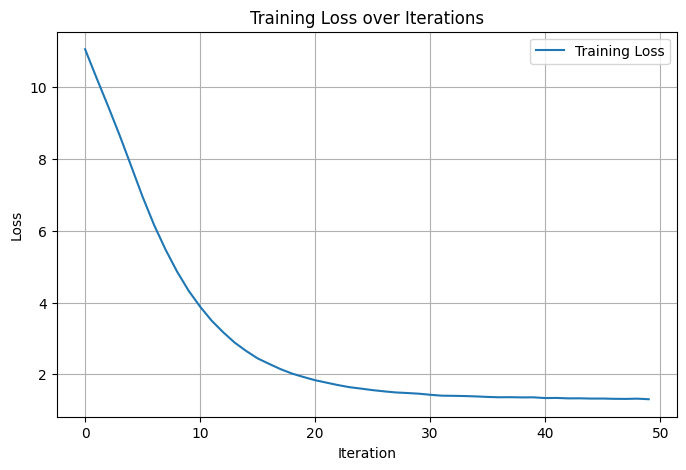

In [87]:
plot_losses(lossess)


In [89]:
generate_text(bilm, text="gov nie dojrze")

'[CLS] gov nie dojrze [SEP] vla postrzegane kolegami bawiacych. plotek roznorodnych wybuch kazdy tego niepo'

### Mathematical trick in self-attention (MASKING)

#### BOW - first version

In [23]:
torch.manual_seed(1337)

B, T, C = 4, 8, 32  # batch, seq_len, channel
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 32])

In [24]:
# version 1

xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, : t + 1]  # (t, C)
        xbow[b, t] = torch.mean(xprev, 0)

xbow

tensor([[[ 1.8077e-01, -6.9988e-02, -3.5962e-01,  ..., -8.0164e-01,
           1.5236e+00,  2.5086e+00],
         [-2.4116e-01, -1.6063e-01,  3.2526e-01,  ...,  3.6581e-01,
           1.5667e+00,  1.0527e+00],
         [-4.3893e-01,  9.2179e-02,  1.9971e-01,  ...,  9.8210e-02,
           7.1071e-01,  5.6531e-01],
         ...,
         [-9.8921e-01,  1.3417e-01,  2.8014e-01,  ...,  3.4951e-01,
           6.1414e-01,  1.2510e-01],
         [-8.2062e-01,  6.6077e-02,  4.9662e-01,  ...,  3.5242e-01,
           4.4703e-01,  5.0332e-02],
         [-7.9077e-01,  3.0213e-02,  4.3624e-01,  ...,  6.9874e-02,
           3.2521e-01,  1.7912e-01]],

        [[ 4.5618e-01, -1.0917e+00, -8.2073e-01,  ...,  5.1187e-02,
          -6.5764e-01, -2.5729e+00],
         [ 2.3859e-01, -4.2831e-02, -1.0349e+00,  ...,  4.1852e-01,
          -9.0388e-01, -6.2984e-01],
         [ 8.9262e-01, -1.0170e-01, -5.0905e-01,  ...,  6.4184e-02,
          -2.4146e-01, -6.8638e-01],
         ...,
         [ 5.6778e-01,  3

#### Trick in self attention

In [25]:
torch.manual_seed(1234)

a = torch.tril(torch.ones(3, 3))

a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3, 2)).float()

c = a @ b

print("a=")
print(a)
print("b=")
print(b)
print("c=")
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b=
tensor([[5., 1.],
        [6., 5.],
        [6., 4.]])
c=
tensor([[5.0000, 1.0000],
        [5.5000, 3.0000],
        [5.6667, 3.3333]])


Wynikiem tego jest to samo co powyzej

In [26]:
torch.tril(torch.ones(3, 3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [ ]:
# version 2
torch.manual_seed(1337)

wei_sqrt = torch.tril(torch.ones(T, T))
wei_sqrt = wei_sqrt / wei_sqrt.sum(1, keepdim=True)
wei_sqrt

xbow2 = wei_sqrt @ x  # (T, T) @ (B, T, C) -> (B, T, C)

torch.allclose(xbow, xbow2, atol=1e-6)

True

In [ ]:
# version 3

tril = torch.tril(torch.ones(T, T))
wei_sqrt = torch.zeros(T, T)
wei_sqrt = wei_sqrt.masked_fill(
    tril == 0, float("-inf")
)  # - nie patrzymy na przyszłość,  zeruje się "future cannot communicate with the past"
wei_sqrt = F.softmax(wei_sqrt, dim=-1)  # -1 -> sum po wierszu

xbow3 = wei_sqrt @ x
torch.allclose(xbow, xbow3, atol=1e-6)

True

In [ ]:
wei_sqrt

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

### Self attention

In [ ]:
torch.manual_seed(1337)

# C = emb_dim
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

# single head attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k: torch.Tensor = key(x)  # (B, T, 16) Q  x @ W_k
q: torch.Tensor = query(x)  # (B, T, 16)  x @ W_q
v = value(x)

wei_sqrt = q @ k.transpose(-2, -1)  # (B, T, T)
tril = torch.tril(torch.ones(T, T))
wei_sqrt = wei_sqrt.masked_fill(tril == 0, float("-inf"))
wei_sqrt = F.softmax(wei_sqrt, dim=-1)

out = wei_sqrt @ v
out.shape
# query - czego szukam
# key - co zawieram
# value - wartość tego co mam do przekazania

torch.Size([4, 8, 16])

In [174]:
out[0]

tensor([[-0.1571,  0.8801,  0.1615, -0.7824, -0.1429,  0.7468,  0.1007, -0.5239,
         -0.8873,  0.1907,  0.1762, -0.5943, -0.4812, -0.4860,  0.2862,  0.5710],
        [ 0.6764, -0.5477, -0.2478,  0.3143, -0.1280, -0.2952, -0.4296, -0.1089,
         -0.0493,  0.7268,  0.7130, -0.1164,  0.3266,  0.3431, -0.0710,  1.2716],
        [ 0.4823, -0.1069, -0.4055,  0.1770,  0.1581, -0.1697,  0.0162,  0.0215,
         -0.2490, -0.3773,  0.2787,  0.1629, -0.2895, -0.0676, -0.1416,  1.2194],
        [ 0.1971,  0.2856, -0.1303, -0.2655,  0.0668,  0.1954,  0.0281, -0.2451,
         -0.4647,  0.0693,  0.1528, -0.2032, -0.2479, -0.1621,  0.1947,  0.7678],
        [ 0.2510,  0.7346,  0.5939,  0.2516,  0.2606,  0.7582,  0.5595,  0.3539,
         -0.5934, -1.0807, -0.3111, -0.2781, -0.9054,  0.1318, -0.1382,  0.6371],
        [ 0.3428,  0.4960,  0.4725,  0.3028,  0.1844,  0.5814,  0.3824,  0.2952,
         -0.4897, -0.7705, -0.1172, -0.2541, -0.6892,  0.1979, -0.1513,  0.7666],
        [ 0.1866, -0.0

### wei raw

In [ ]:
wei_sqrt[0]

# wei[b, i, j] = jak bardzo token i (query) pasuje do tokenu j (key)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

### wei softmax


In [ ]:
tril = torch.tril(torch.ones(T, T))
wei_sqrt = wei_sqrt.masked_fill(tril == 0, float("-inf"))
wei_sqrt = F.softmax(wei_sqrt, dim=-1)

wei_sqrt[0]

# wei[b, i, j] = jak bardzo token i (query) pasuje do tokenu j (key)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3351, 0.6649, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2877, 0.2753, 0.4370, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3407, 0.2150, 0.2306, 0.2138, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1604, 0.1730, 0.1632, 0.1601, 0.3434, 0.0000, 0.0000, 0.0000],
        [0.1387, 0.1784, 0.1393, 0.1375, 0.2694, 0.1366, 0.0000, 0.0000],
        [0.1455, 0.1845, 0.1284, 0.1281, 0.1364, 0.1502, 0.1270, 0.0000],
        [0.1122, 0.1195, 0.1161, 0.1382, 0.1164, 0.1179, 0.1400, 0.1396]],
       grad_fn=<SelectBackward0>)

skończone na 1:13:23 filmiku https://www.youtube.com/watch?v=kCc8FmEb1nY&t=5065s

### Why scaled dot attention? Why scaling?

In [ ]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)

wei = q @ k.transpose(-2, -1)

In [39]:
print(f"k.var={k.var()}")
print(f"q.var={q.var()}")
print(f"wei.var={wei.var()}")

wei_sqrt = q @ k.transpose(-2, -1) * head_size**-0.5
print(f"wei_sqrt.var={wei_sqrt.var()}")


k.var=1.0966005325317383
q.var=0.9415779113769531
wei.var=16.10364532470703
wei_sqrt.var=1.0064778327941895


Dzięki temu są stailniejsze obliczenia